In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from __future__ import division, print_function
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import h5py
import pandas as pd
from scipy import interpolate, optimize
from kpfm.util import align_labels

def db(x):
    return 20*np.log10(x)

In [2]:
plt.rc('font', size=8)

# Experimental parameters

- Cantilever: f0 = 70367, tip-sample distance: 10 V on piezo = 300 nm + 25 nm (50-percent amplitude setpoint) from surface = 325 nm. At this distance α = 0.52 Hz/V², determined by frequency shift vs. voltage parabola.
- Photo-detector: 200 kHz LP, 300 Hz HP, 3e3 gain setting
- RHK: I = -10.0 Hz/deg, P = 2.5 Hz, frequency shift gain = 20 Hz/V
- SRS: 10 ms TC, sens = 1 V (for measurements at 160 Hz modulation frequency), SYNC filter ON, 6 dB/octave
- PID: I = 50 s⁻¹, D = 5e-5 s, P variable to meet gain margin criteria

Loop unstable at P = 5.6 to 5.8

The test excitation signal was provided by a Perkins Elmer 7265 LIA. rms-modulation amplitude Vrms = 0.5 V, sensitivity = 1 V (10 V full scale, so that the unit conversion factor is $\phi(\text{x-channel}) = 0.1 X$.

Therefore, the transfer function magnitude is obtained by dividing the measured $X$, $Y$ lock-in outputs by $5 \, \text{V}$.

In [3]:
PID_P_gain = np.array([-1.9, -2.8, -0.6])
gain_margin = np.array([3, 2, 10])
fnames = ['170616-123218-bode-plot.tsv', '170616-123815-bode-plot.tsv', '170616-124323-bode-plot.tsv']
fname = fnames[0]

In [4]:
dfs = [pd.read_table('../data/bode/'+fname) for fname in fnames]
f = dfs[0]['Frequency [Hz]'].values
signals = [((df["X [V]"] + df["Y [V]"]*1j).values * -1 /  5) for df in dfs]

In [5]:
out = signals[-1] / (1-signals[-1])  # Adjust P gain of output to 1.3
s3 = out*1.3/0.6 / (1 + out*1.3/0.6)

In [6]:
ss = [signals[0], s3,  signals[1],]

In [7]:
interps_95 = [interpolate.interp1d(f, 20*np.log10(abs(signal))-20*np.log10(0.95)) for signal in ss]
interps = [interpolate.interp1d(f, 20*np.log10(abs(signal))-20*np.log10(0.707)) for signal in ss]

In [8]:
-20*np.log10(0.707)

3.0116117240620124

In [9]:
bandwidths = [optimize.fsolve(interp, 30)[0] for interp in interps]

/Users/ryandwyer/anaconda/lib/python2.7/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [10]:
bandwidths_95 = [optimize.fsolve(interp, 20)[0] for interp in interps_95]

In [11]:
bandwidths_95

[11.154801389300671, 17.668523953583858, 8.6851315713258632]

(-12, 6)

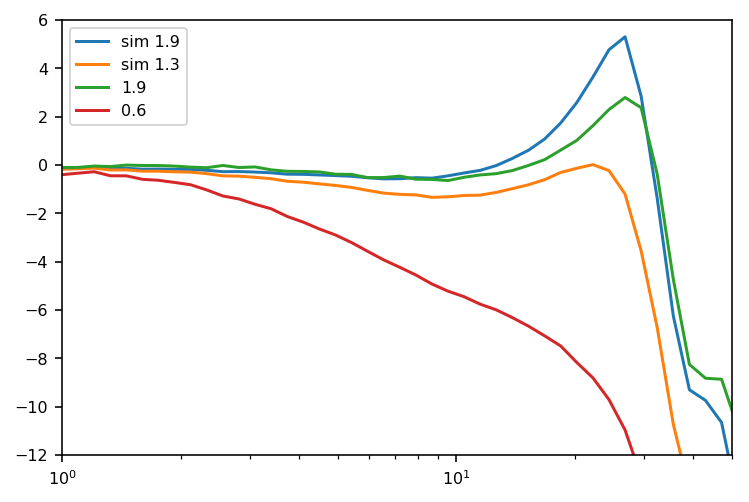

In [12]:
plt.semilogx(f, db(abs(out*1.9/0.6 / (1 + out*1.9/0.6))), label='sim 1.9')
plt.semilogx(f, db(abs(out*1.3/0.6 / (1 + out*1.3/0.6))), label='sim 1.3')
plt.semilogx(f, db(abs(signals[0])), label='1.9')
plt.semilogx(f, db(abs(signals[-1])), label='0.6')
plt.legend()
plt.xlim(1, 50)
plt.ylim(-12, 6)

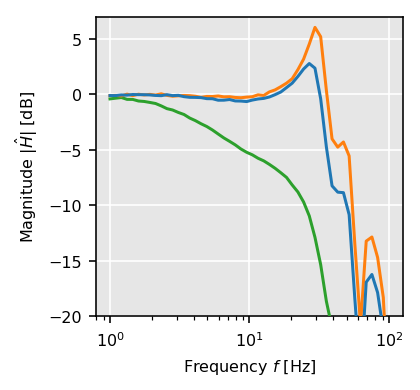

In [13]:
fig, ax = plt.subplots(figsize=(2.75, 2.75), subplot_kw=dict(facecolor='0.9'))

ax.grid(color='1')

zorder = 5
for fname in fnames:
    df1 = pd.read_table('../data/bode/'+fname)
    signal = ((df1["X [V]"] + df1["Y [V]"]*1j).values * -1 /  5)
    ax.semilogx(df1["Frequency [Hz]"].values, 20*np.log10(abs(signal)), zorder=zorder)
    
    zorder -= 1
    
ax.set_ylim(-20, 7)
ax.set_ylabel(u"Magnitude $|\\hat{H}|$ [dB]")
ax.set_xlabel(u"Frequency $f$ [Hz]")

In [14]:
# Run another experiment at 0.25 gain margin!

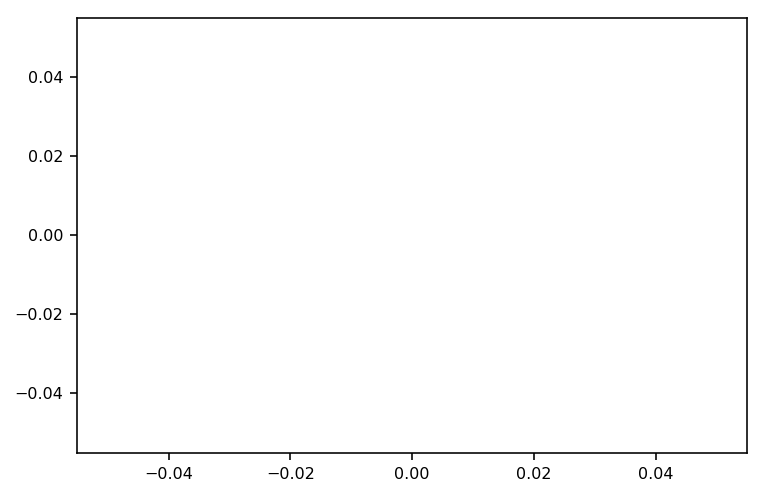

In [15]:
dc = [plt.plot(0,0)[0].get_color() for i in xrange(10)]

In [16]:
interps

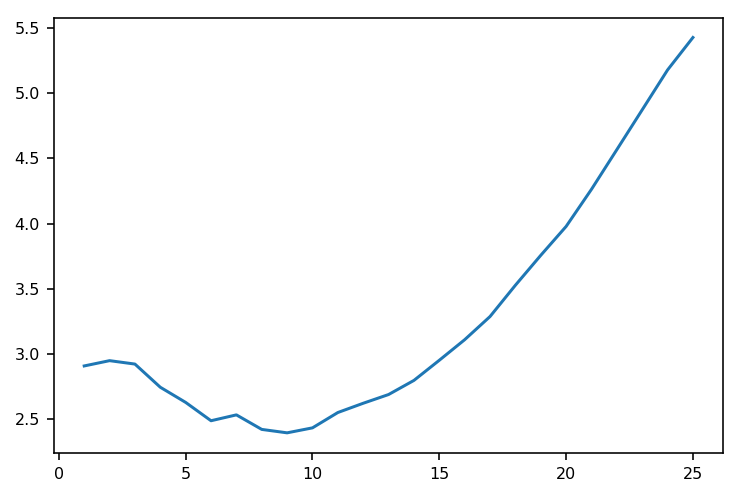

In [17]:
plt.plot(np.arange(25)+1, interps[0](np.arange(25)+1))

In [18]:
blue = dc[0]

In [19]:
color_midpoints = ['#83AFCE', "#89C48A", '#BDA7D3']

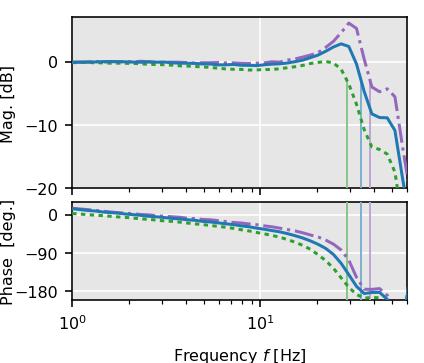

In [20]:
fig, (ax, ax2) = plt.subplots(figsize=(3, 2.6), subplot_kw=dict(facecolor='0.9'),
                              nrows=2, sharex=True,
                              gridspec_kw=dict(height_ratios=(1.75, 1))
                             )

ax.grid(color='1')
ax2.grid(color='1')

fig.subplots_adjust(hspace=0.1)


zorder = 10
formats = [dict(color=blue), dict(color=dc[2], linestyle=":"), dict(color=dc[4], linestyle="-.")]
for form, signal in zip(formats, ss):
    ax.semilogx(f, 20*np.log10(abs(signal)), zorder=zorder, **form)
    
    ax2.semilogx(f, 180/np.pi*np.unwrap(np.angle(signal)),zorder=zorder, **form)
    
    zorder -= 1

b = 34.3

for c, b in zip(color_midpoints, bandwidths):
    ax.axvline(b,  0, 0.63, linewidth=1, color=c, zorder=3)

    ax2.axvline(b, linewidth=1,color=c, zorder=3)

ax.set_ylim(-20, 7)

ax.set_ylabel(u"Mag. [dB]")
ax2.set_ylabel("Phase  [deg.]")
ax2.set_xlabel(u"Frequency $f$ [Hz]")
ax.set_yticks([-20, -10, 0])
ax2.set_yticks([-180, -90, 0])
ax2.set_ylim(-200, 30)
ax2.set_xlim(1, 60)


align_labels([ax, ax2], 16)
align_labels([ax2], 17, 'x')

In [29]:
fig.savefig('../figs/102cd-bode.pdf', bbox_inches='tight', pad_inches=0.25)

In [22]:
# !open -a "Preview" ../figs/mag-phase.pdf

In [23]:
np.set_printoptions(precision=3, suppress=True)
20*np.log10(abs(signal)) 

array([ -0.103,  -0.086,  -0.138,   0.027,  -0.108,   0.019,  -0.048,
         0.006,  -0.055,   0.057,  -0.088,  -0.163,  -0.124,  -0.092,
        -0.109,  -0.163,  -0.261,  -0.181,  -0.188,  -0.138,  -0.217,
        -0.205,  -0.273,  -0.298,  -0.243,  -0.207,  -0.034,  -0.091,
         0.231,   0.41 ,   0.701,   1.018,   1.42 ,   2.239,   3.186,
         4.549,   6.057,   5.216,   0.382,  -4.013,  -4.76 ,  -4.294,
        -5.553, -13.497, -20.835, -13.247, -12.874, -14.718, -18.335,
       -28.149])

In [25]:
df1['Frequency [Hz]'][i-1:i+1]

8    2.120951
9    2.329952
Name: Frequency [Hz], dtype: float64

In [26]:
mb = np.polyfit(df1['Frequency [Hz]'][i-1:i+1], [-0.386,  -4.729,], 1)

In [27]:
(-3 - mb[1]) / mb[0]

2.2467460557563896

In [28]:
20*np.log10(abs(signal))

array([ -0.103,  -0.086,  -0.138,   0.027,  -0.108,   0.019,  -0.048,
         0.006,  -0.055,   0.057,  -0.088,  -0.163,  -0.124,  -0.092,
        -0.109,  -0.163,  -0.261,  -0.181,  -0.188,  -0.138,  -0.217,
        -0.205,  -0.273,  -0.298,  -0.243,  -0.207,  -0.034,  -0.091,
         0.231,   0.41 ,   0.701,   1.018,   1.42 ,   2.239,   3.186,
         4.549,   6.057,   5.216,   0.382,  -4.013,  -4.76 ,  -4.294,
        -5.553, -13.497, -20.835, -13.247, -12.874, -14.718, -18.335,
       -28.149])